# Adaptive Exponential IF neuron

Download the Jupyter notebook: [AdEx.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/AdEx.ipynb){target="_blank"} or run it directly on [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/AdEx.ipynb){target="_blank"}

This notebook explores how the AdEx neuron model can reproduce various spiking patterns observed in vivo.

Code based on @Naud2008:

> Naud, R., Marcille, N., Clopath, C., and Gerstner, W. (2008). Firing patterns in the adaptive exponential integrate-and-fire model. Biol Cybern 99, 335. [doi:10.1007/s00422-008-0264-7](https://link.springer.com/article/10.1007/s00422-008-0264-7).

Uncomment on colab:

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *

clear()
setup(dt=0.1)

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


The AdEx neuron is defined by the following equations:

$$
    C \, \frac{dv}{dt} = -g_L \ (v - E_L) + g_L \, \Delta_T \, \exp(\frac{v - v_T}{\Delta_T}) + I - w
$$

$$
    \tau_w \, \frac{dw}{dt} = a \, (v - E_L) - w
$$

if $v > v_\text{spike}$:

* $v = v_R$
* $w = w + b$

In [3]:
AdEx = Neuron(
    parameters="""
        C = 200.
        gL = 10. # not g_L! g_ is reserved for spike transmission
        E_L = -70.
        v_T = -50.
        delta_T = 2.0
        a = 2.0
        tau_w = 30.
        b = 0.
        v_r = -58.
        I = 500.
        v_spike = 0.0 
    """,
    equations="""
        C * dv/dt = - gL * (v - E_L) +  gL * delta_T * exp((v-v_T)/delta_T) + I - w : init=-70.0     
        
        tau_w * dw/dt = a * (v - E_L) - w  : init=0.0
    """,
    spike="""
        v >= v_spike
    """,
    reset="""
        v = v_r
        w += b
    """,
    refractory = 2.0
)

We create a population of 1 AdEx neurons which will get different parameter values.

In [4]:
pop = Population(1, AdEx)

In [5]:
compile()

Compiling ...  OK 


We add a monitor to track the membrane potential and the spike timings during the simulation.

In [6]:
m = Monitor(pop, ['v', 'spike'])

Following (Naud et al, 2008), we provide different parameter values corresponding to eight different firing patterns:

1. tonic spiking 
2. adaptation, 
3. initial burst, 
4. regular bursting, 
5. delayed accelerating, 
6. delayed regular bursting, 
7. transcient spiking, 
8. irregular spiking.

In [7]:
# a) tonic spiking b) adaptation, c) initial burst, d) regular bursting, e) delayed accelerating, f) delayed regular bursting, g) transcient spiking, h) irregular spiking
C =       [200, 200, 130, 200, 200, 200, 100, 100]
gL =      [ 10,  12,  18,  10,  12,  12,  10,  12]
E_L =     [-70, -70, -58, -58, -70, -70, -65, -60]
v_T =     [-50, -50, -50, -50, -50, -50, -50, -50]
delta_T = [  2,   2,   2,   2,   2,   2,   2,   2]
a =       [  2,   2,   4,   2,-10., -6.,-10.,-11.]
tau_w =   [ 30, 300, 150, 120, 300, 300,  90, 130]
b =       [  0,  60, 120, 100,   0,   0,  30,  30]
v_r =     [-58, -58, -50, -46, -58, -58, -47, -48]
I =       [500, 500, 400, 210, 300, 110, 350, 160]

In the `trial()` method, we simulate the network for 500 ms with a fixed input current, and remove that current for an additional 50 ms.

In [8]:
def trial(C, gL, E_L, v_T, delta_T, a, tau_w, b, v_r, I):

    # Reset neuron
    reset()

    # Set parameters
    pop.C = C; pop.gL = gL; pop.E_L = E_L; pop.v_T = v_T; pop.delta_T = delta_T
    pop.a = a; pop.tau_w = tau_w; pop.b = b; pop.v_r = v_r; pop.I = I 

    # Simulate
    simulate(500.)
    pop.I = 0.0
    simulate(50.)

    # Recordings
    data = m.get('v')
    spikes = m.get('spike')
    for n, t in spikes.items(): # Normalize the spikes
        data[[x  for x in t], n] = 0.0

    return data

We can now visualize the membrane potential for the different neuron types:

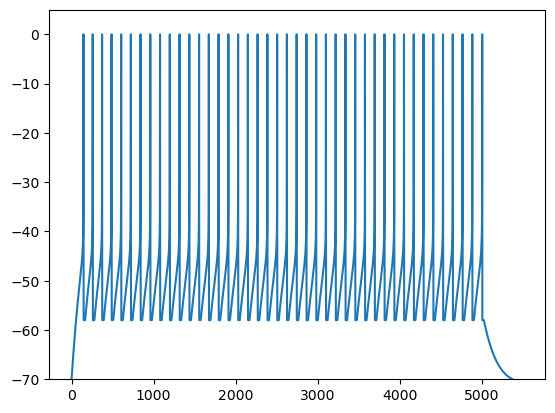

In [9]:
idx = 0
data = trial(C[idx], gL[idx], E_L[idx], v_T[idx], delta_T[idx], a[idx], tau_w[idx], b[idx], v_r[idx], I[idx])

plt.figure()
plt.plot(data[:, 0])
plt.ylim((-70., 5.))
plt.show()

**Experiments**

1. Visualize the firing patterns for the 8 neuron types and compare them to the figure in Naud et al. (2008).
2. For the tonic firing neuron, vary the refractory period to observe its influence on the firing pattern. 
3. What is the minimum value of `I` allowing the tonic firing neuron to spike?